# Result prediction based on Poison simulations

Source data: https://www.football-data.co.uk/englandm.php

And: https://fixturedownload.com/results/epl-2020

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
game_week = 7

In [3]:
converter = {
    "Man Utd": "Man United",
    "Sheffield Utd": "Sheffield United",
    "Spurs": "Tottenham",
}

def convert_team(team):
    if team in converter.keys():
        return converter[team]
    return team


fix = pd.read_csv("data/epl-2020-GMTStandardTime.csv")

fix["Home Team"] = fix["Home Team"].apply(convert_team)
fix["Away Team"] = fix["Away Team"].apply(convert_team)

In [4]:
fix[fix["Round Number"] == game_week]

,Round Number,Date,Location,Home Team,Away Team,Result
60,7,30/10/2020 20:00,Molineux Stadium,Wolves,Crystal Palace,NaN
61,7,31/10/2020 15:00,Turf Moor,Burnley,Chelsea,NaN
62,7,31/10/2020 15:00,Elland Road,Leeds,Leicester,NaN
63,7,31/10/2020 15:00,Anfield,Liverpool,West Ham,NaN
64,7,31/10/2020 15:00,Old Trafford,Man United,Arsenal,NaN
65,7,31/10/2020 15:00,St. James' Park,Newcastle,Everton,NaN
66,7,31/10/2020 15:00,Bramall Lane,Sheffield United,Man City,NaN
67,7,01/11/2020 12:00,Villa Park,Aston Villa,Southampton,NaN
68,7,01/11/2020 19:15,Tottenham Hotspur Stadium,Tottenham,Brighton,NaN
69,7,02/11/2020 17:30,Craven Cottage,Fulham,West Brom,NaN


In [5]:
csv_files = {
    "https://www.football-data.co.uk/mmz4281/2021/E0.csv": "2020-21",  # Refresh with latest results
    #    "data/E2020_21.csv": "2020-21",
    "data/E2019_20.csv": "2019-20",
    "data/E2018_19.csv": "2018-19",
    "data/E2017_18.csv": "2017-18",
    "data/E2016_17.csv": "2016-17",
    "data/E2015_16.csv": "2015-16",
    "data/E2014_15.csv": "2014-15",
}

df = pd.DataFrame()

for file, season in csv_files.items():
    _data = pd.read_csv(file)
    _data["Season"] = season
    df = df.append(_data)
    
df.shape

(2339, 131)

In [6]:
cols = [
    "Season",
    "Date",
    "HomeTeam",
    "AwayTeam",
    "FTHG",
    "FTAG",
    "FTR",
]

df = df[cols]
df["Date"] = pd.to_datetime(df["Date"])
df["TG"] = df["FTHG"] + df["FTAG"]

df.sample(5)

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,TG
0,2017-18,2017-11-08,Arsenal,Leicester,4.0,3.0,H,7.0
240,2015-16,2016-06-02,Aston Villa,Norwich,2.0,0.0,H,2.0
32,2019-20,2019-08-31,Crystal Palace,Aston Villa,1.0,0.0,H,1.0
25,2020-21,2020-09-27,West Ham,Wolves,4.0,0.0,H,4.0
31,2020-21,2020-03-10,Newcastle,Burnley,3.0,1.0,H,4.0


In [7]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2338 entries, 0 to 379
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Season    2338 non-null   object        
 1   Date      2338 non-null   datetime64[ns]
 2   HomeTeam  2338 non-null   object        
 3   AwayTeam  2338 non-null   object        
 4   FTHG      2338 non-null   float64       
 5   FTAG      2338 non-null   float64       
 6   FTR       2338 non-null   object        
 7   TG        2338 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 164.4+ KB


In [8]:
df.sample(5)

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,TG
95,2019-20,2019-10-26,Burnley,Chelsea,2.0,4.0,A,6.0
306,2019-20,2020-06-24,Liverpool,Crystal Palace,4.0,0.0,H,4.0
149,2016-17,2016-11-12,Southampton,Middlesbrough,1.0,0.0,H,1.0
238,2014-15,2015-08-02,Newcastle,Stoke,1.0,1.0,D,2.0
10,2014-15,2014-08-23,Aston Villa,Newcastle,0.0,0.0,D,0.0


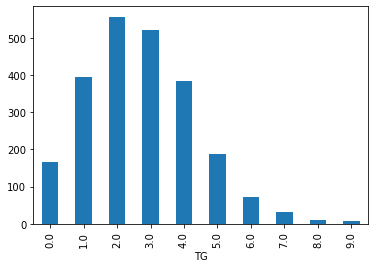

In [9]:
df.groupby("TG")["TG"].count().plot.bar();

# Head to Head Pivot

In [10]:
head_to_head = df.groupby(["HomeTeam", "AwayTeam"]).agg(
    Matches=pd.NamedAgg(column="FTHG", aggfunc="count"),
    HSavg=pd.NamedAgg(column="FTHG", aggfunc="mean"),
    ASavg=pd.NamedAgg(column="FTAG", aggfunc="mean"),
)

head_to_head.shape

(772, 3)

In [11]:
head_to_head.reset_index().sample(5)

,HomeTeam,AwayTeam,Matches,HSavg,ASavg
516,Sheffield United,Arsenal,1,1.0,0.0
282,Huddersfield,West Brom,1,1.0,0.0
473,Newcastle,Wolves,2,1.0,1.5
525,Sheffield United,Leeds,1,0.0,1.0
276,Huddersfield,Newcastle,2,0.5,0.5


# Simulation function

In [12]:
def get_result(h_score, a_score):
    if h_score > a_score:
        return "H"
    elif a_score > h_score:
        return "A"
    else:
        return "D"


def get_sim(home, away):
    if (home, away) not in head_to_head.index:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 # Return 0 if no previoous fixtures

    n_sim = 500
    score_sim = []
    result_sim = {"H": 0, "D": 0, "A": 0}

    for i in range(n_sim):
        h_score = np.random.poisson(head_to_head.loc[home, away]["HSavg"], 1)
        a_score = np.random.poisson(head_to_head.loc[home, away]["ASavg"], 1)
        score_sim.append((h_score[0], a_score[0]))
        result_sim[get_result(h_score, a_score)] += 1

    score_occ = Counter(score_sim)

    return (
        head_to_head.loc[home, away]["Matches"],  # Previous matches
        head_to_head.loc[home, away]["HSavg"],  # Average Home Score
        head_to_head.loc[home, away]["ASavg"],  # Average Away Score
        score_occ.most_common(1)[0][0][0],  # Most common Home Score
        score_occ.most_common(1)[0][0][1],  # Most common Away Score
        score_occ.most_common(1)[0][1] / n_sim,  # % likelyhood of the most common score
        result_sim["H"],  # Number of home Wins in the simulation
        result_sim["D"],  # Number of Draws in the simulation
        result_sim["A"],  # Number of away win (home loss) in the simulation
        result_sim["H"] / n_sim,  # Likelihood of home win
        result_sim["D"] / n_sim,  # Likelihood of a draw
        result_sim["A"] / n_sim,  # Likelyhood of away win
    )

In [13]:
get_sim("West Ham", "Man City")

(7.0, 0.8571428571428571, 3.0, 0, 4, 0.086, 33, 71, 396, 0.066, 0.142, 0.792)

# Game_week 2020 simulation

In [14]:
matches = fix[fix["Round Number"] == game_week][["Home Team", "Away Team"]].to_numpy()

print(game_week)
matches

7


array([['Wolves', 'Crystal Palace'],
       ['Burnley', 'Chelsea'],
       ['Leeds', 'Leicester'],
       ['Liverpool', 'West Ham'],
       ['Man United', 'Arsenal'],
       ['Newcastle', 'Everton'],
       ['Sheffield United', 'Man City'],
       ['Aston Villa', 'Southampton'],
       ['Tottenham', 'Brighton'],
       ['Fulham', 'West Brom']], dtype=object)

In [15]:
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: green" if v else "" for v in is_max]


def highlight_low(s):
    return "background-color: orange" if s < 3 else ""


def add_sim(row):
    return get_sim(row["HomeTeam"], row["AwayTeam"])


pl = pd.DataFrame(matches, columns=["HomeTeam", "AwayTeam"])

pl[
    [
        "Matches",
        "HSavg",
        "ASavg",
        "HSsim",
        "ASsim",
        "p%",
        "H",
        "D",
        "A",
        "H%",
        "D%",
        "A%",
    ]
] = pl.apply(add_sim, axis=1, result_type="expand")

pl.style.apply(highlight_max, subset=["H%", "D%", "A%"], axis=1).applymap(
    highlight_low, subset=["Matches"]
).format(
    {
        "Matches": "{:,.0f}",
        "HSavg": "{:,.2f}",
        "ASavg": "{:,.2f}",
        "HSsim": "{:,.0f}",
        "ASsim": "{:,.0f}",
        "p%": "{:,.0%}",
        "H": "{:,.0f}",
        "D": "{:,.0f}",
        "A": "{:,.0f}",
        "H%": "{:,.0%}",
        "D%": "{:,.0%}",
        "A%": "{:,.0%}",
    }
)

,HomeTeam,AwayTeam,Matches,HSavg,ASavg,HSsim,ASsim,p%,H,D,A,H%,D%,A%
0,Wolves,Crystal Palace,2,1.00,1.00,0,1,16%,183,146,171,37%,29%,34%
1,Burnley,Chelsea,5,1.00,2.80,1,2,10%,53,77,370,11%,15%,74%
2,Leeds,Leicester,0,0.00,0.00,0,0,0%,0,0,0,0%,0%,0%
3,Liverpool,West Ham,6,2.50,1.33,2,1,9%,313,95,92,63%,19%,18%
4,Man United,Arsenal,6,1.67,1.33,1,1,11%,228,126,146,46%,25%,29%
5,Newcastle,Everton,5,1.40,1.60,1,2,11%,184,120,196,37%,24%,39%
6,Sheffield United,Man City,1,0.00,1.00,0,1,37%,0,178,322,0%,36%,64%
7,Aston Villa,Southampton,3,1.33,2.67,1,3,9%,84,86,330,17%,17%,66%
8,Tottenham,Brighton,3,1.67,0.33,1,0,26%,370,96,34,74%,19%,7%
9,Fulham,West Brom,0,0.00,0.00,0,0,0%,0,0,0,0%,0%,0%
